# Nearest neighbor with KDTree


In [28]:
from scipy.spatial import KDTree, distance
import numpy as np
from pprint import pp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
# Example
points_ref = np.array([(1, 1), (3, 3), (4, 4), (5, 4), (6, 6)])
refTree = KDTree(points_ref)
idx = refTree.query_ball_point((4, 4), 2)
pp(idx)
pp(points_ref[idx])

[1, 2, 3]
array([[3, 3],
       [4, 4],
       [5, 4]])


In [30]:
# Constructing centroids of zones
ncol = 2
nZones = 6
nrows = nZones

# Make sure I have unique index
idxStart = random.randint(100, 200)
cols = [f"W{i+1}" for i in range(ncol)]
idx = [f"c{i+idxStart}" for i in range(nrows)]
X = pd.DataFrame(np.random.random(size=(nrows, ncol)), columns=cols, index=idx)
y = [i for i in range(nrows)]
y = pd.Series(y, index=idx, name="cy")
zc = pd.concat([y, X], axis=1)
zc = zc.sample(frac=1)
display(zc)

,cy,W1,W2
c180,1,0.915708,0.487057
c183,4,0.100003,0.347446
c184,5,0.584036,0.725421
c182,3,0.509589,0.889829
c179,0,0.727394,0.615786
c181,2,0.846095,0.791373


In [31]:
# Constructing unsupervised fingerprints
nrows = 200
idxStart = random.randint(100, 200)
idx = [f"u{i+idxStart}" for i in range(nrows)]
uFp = pd.DataFrame(np.random.random(size=(nrows, ncol)), columns=cols, index=idx)
display(uFp)

,W1,W2
u142,0.171844,0.139596
u143,0.022451,0.828756
u144,0.920003,0.648119
u145,0.266876,0.119720
u146,0.913703,0.598752
...,...,...
u337,0.483421,0.224790
u338,0.786559,0.006977
u339,0.640018,0.261737
u340,0.045469,0.499060


<Axes: xlabel='W1', ylabel='W2'>

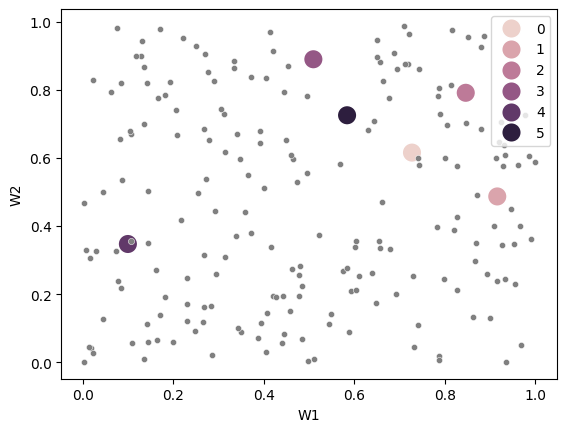

In [32]:
fig, ax = plt.subplots()
sns.scatterplot(zc, x="W1", y="W2", hue="cy", ax=ax, s=200)
sns.scatterplot(uFp, x="W1", y="W2", ax=ax, color="gray", s=20)

In [33]:
# Find nearest neighbors
refPts = zc[cols]
refLabels = zc["cy"]
queryPts = zc[cols]
removeSelf = True
k = 6

# ---------------------------------
refTree = KDTree(refPts)
distArr, idxArr = refTree.query(queryPts, k=k)
pp(idxArr)
pp(distArr)


def rowFn(row, refPts, refLabels):
    k = int(row.shape[0] / 2)
    srIdx = row.iloc[:k].reset_index(drop=True).astype(int)
    nnCy = srIdx.apply(
        lambda idx: refLabels.iloc[idx] if idx < refLabels.shape[0] else None
    )
    nnCyIdx = srIdx.apply(
        lambda idx: refPts.index.values[idx] if idx < refPts.shape[0] else None
    )

    nnCyDist = row.iloc[k:].reset_index(drop=True)
    nnCyDist.replace([np.inf, -np.inf], None, inplace=True)
    dft = pd.DataFrame({"nnCy": nnCy, "nnCyDist": nnCyDist, "nnCyIdx": nnCyIdx})
    dft = dft[dft["nnCyDist"] != 0] # Drop self point
    dft = dft.dropna() # Drop invalid entries
    
    
    res = pd.Series(
        [
            dft["nnCy"].values.tolist(),
            dft["nnCyDist"].values.tolist(),
            dft["nnCyIdx"].values.tolist(),
            dft.shape[0],
        ],
        index=["nnCy", "nnCyDist", "nnCyIdx", "nnCyK"],
    )
    return res


dft = pd.DataFrame(np.concatenate([idxArr, distArr], axis=1), index=queryPts.index)
zcSelfNn = dft.apply(lambda row: rowFn(row, refPts, refLabels), axis=1)
display(zcSelfNn)

array([[0, 4, 5, 2, 3, 1],
       [1, 2, 3, 4, 0, 5],
       [2, 4, 3, 5, 0, 1],
       [3, 2, 4, 5, 0, 1],
       [4, 2, 5, 0, 3, 1],
       [5, 4, 2, 0, 3, 1]], dtype=int64)
array([[0.        , 0.22810778, 0.3121759 , 0.40844072, 0.57197667,
        0.82756578],
       [0.        , 0.61412762, 0.67966132, 0.68236794, 0.82756578,
        0.86817327],
       [0.        , 0.18047581, 0.1804774 , 0.27023142, 0.40844072,
        0.61412762],
       [0.        , 0.1804774 , 0.35005478, 0.35061417, 0.57197667,
        0.67966132],
       [0.        , 0.18047581, 0.21194483, 0.22810778, 0.35005478,
        0.68236794],
       [0.        , 0.21194483, 0.27023142, 0.3121759 , 0.35061417,
        0.86817327]])


,nnCy,nnCyDist,nnCyIdx,nnCyK
c180,"[0, 2, 5, 3, 4]","[0.2281077781591589, 0.3121758981280273, 0.408...","[c179, c181, c184, c182, c183]",5
c183,"[5, 3, 0, 1, 2]","[0.6141276241522959, 0.6796613178859139, 0.682...","[c184, c182, c179, c180, c181]",5
c184,"[0, 3, 2, 1, 4]","[0.18047580749276662, 0.18047740018551367, 0.2...","[c179, c182, c181, c180, c183]",5
c182,"[5, 0, 2, 1, 4]","[0.18047740018551367, 0.3500547833446686, 0.35...","[c184, c179, c181, c180, c183]",5
c179,"[5, 2, 1, 3, 4]","[0.18047580749276662, 0.2119448326167816, 0.22...","[c184, c181, c180, c182, c183]",5
c181,"[0, 5, 1, 3, 4]","[0.2119448326167816, 0.27023142371984, 0.31217...","[c179, c184, c180, c182, c183]",5


In [34]:
refPts = uFp[cols]
queryPts = zc[cols]
queryRadius = zcSelfNn["nnCyDist"].apply(lambda d: d[0])
queryRadius = queryRadius * 0.5  # Half distance to nearnest neighbor


def getNN(row, refTree, refPts):
    radius = row["radius"]
    srIdx = [idx for idx in row.index if idx not in ["radius"]]
    pt = row[srIdx]
    nnIdx = refTree.query_ball_point(pt, radius)

    refPtsSelected = refPts.iloc[nnIdx, :]
    _dists = distance.cdist([pt], refPtsSelected)
    dists = pd.Series(_dists[0], index=refPtsSelected.index, name="nnAugDist")
    dft = pd.concat([refPtsSelected, dists], axis=1)
    dft = dft.sort_values(by="nnAugDist")
    dft = dft[dft["nnAugDist"]!=0]
    res = pd.Series(
        [dft.index.values.tolist(), dft["nnAugDist"].values.tolist(), dft.shape[0]],
        index=["nnAugIdx", "nnAugDist", "nnAugK"],
    )
    return res


refTree = KDTree(refPts)
queryRadius.name = "radius"
dft = pd.concat([queryPts, queryRadius], axis=1)
zcAug = dft.apply(lambda row: getNN(row, refTree, refPts), axis=1)
display(zcAug)

,nnAugIdx,nnAugDist,nnAugK
c180,"[u246, u305, u227, u193, u274, u219, u245, u146]","[0.0445438789638486, 0.04739910593409592, 0.08...",8
c183,"[u233, u185, u173, u163, u253, u259, u294, u19...","[0.0095136511120619, 0.03320494548750902, 0.04...",38
c184,"[u184, u332]","[0.061421555998418725, 0.06318541328600141]",2
c182,[u317],[0.058036411053494844],1
c179,"[u148, u270, u183]","[0.021067700670323933, 0.03948957063054103, 0....",3
c181,"[u286, u292, u320, u149, u256, u254]","[0.038698312543328284, 0.05972050532157042, 0....",6


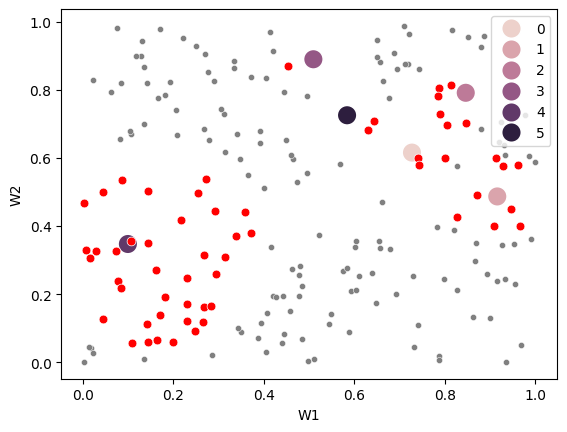

In [35]:
fig, ax = plt.subplots()
sns.scatterplot(zc, x="W1", y="W2", hue="cy", ax=ax, s=200)
sns.scatterplot(uFp, x="W1", y="W2", ax=ax, color="gray", s=20)

for idx in zc.index:
    idxAug = zcAug.loc[idx, "nnAugIdx"]
    augPts = uFp.loc[idxAug, :]
    sns.scatterplot(augPts, x="W1", y="W2", ax=ax, color="red", s=40)